In [81]:
import pandas as pd
import numpy as np
import scipy.stats as stats 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import random
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
from factor_analyzer.factor_analyzer import calculate_kmo

In [82]:
# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)
# Configuración para mostrar todas las filas
pd.set_option('display.max_rows', None)
archivo_csv = "movies_modified.csv"
datos = pd.read_csv(archivo_csv, encoding='ISO-8859-1')

In [83]:
columnas_numericas = datos.select_dtypes(include=['number']).columns.tolist()

# Obtener los nombres de las columnas no numéricas
columnas_no_numericas = datos.select_dtypes(exclude=['number']).columns.tolist()
print("Columnas numéricas:")
print(columnas_numericas)

print("\nColumnas no numéricas:")
print(columnas_no_numericas)

Columnas numéricas:
['id', 'budget', 'revenue', 'runtime', 'popularity', 'voteAvg', 'voteCount', 'genresAmount', 'productionCoAmount', 'productionCountriesAmount', 'actorsAmount', 'castWomenAmount', 'castMenAmount']

Columnas no numéricas:
['genres', 'homePage', 'productionCompany', 'productionCompanyCountry', 'productionCountry', 'video', 'director', 'actors', 'actorsPopularity', 'actorsCharacter', 'originalTitle', 'title', 'originalLanguage', 'releaseDate']


In [84]:
# Lista de columnas numéricas que usaremos
columnas_numericas = [
    "popularity", "budget", "revenue", "runtime", "genresAmount", 
    "productionCoAmount", "productionCountriesAmount", "voteCount", 
    "voteAvg","actorsAmount", "castWomenAmount", "castMenAmount"
]

# Crear un nuevo DataFrame con solo estas columnas
datos_numericos = datos[columnas_numericas].copy()

# 1.1 Preprocesamiento del dataset #

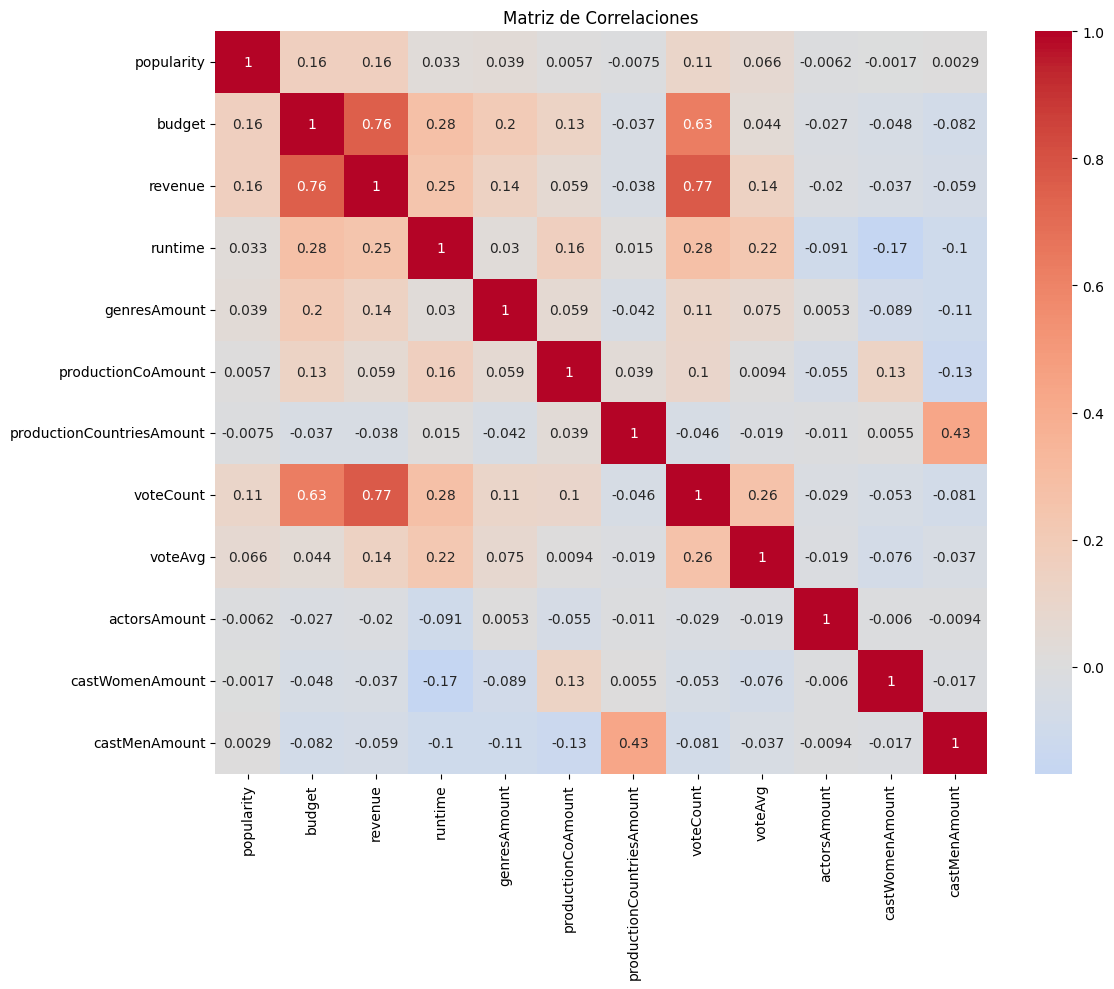

In [85]:
def hopkins_statistic(X):
    X = np.asarray(X)
    n_samples = len(X)
    n_dims = X.shape[1]

    X_uniform = np.random.uniform(
        np.min(X, axis=0),
        np.max(X, axis=0),
        size=(n_samples, n_dims)
    )
    

    neigh = NearestNeighbors(n_neighbors=2)
    neigh.fit(X)
    
    # Distancias para puntos reales
    u_distances, _ = neigh.kneighbors(X_uniform, n_neighbors=1)
    w_distances, _ = neigh.kneighbors(X, n_neighbors=2)
    
    # Calcular estadístico de Hopkins
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances[:, 1])  
    
    return u_sum / (u_sum + w_sum)

# Seleccionar las columnas numéricas
X = datos_numericos[columnas_numericas]

# Calcular matriz de correlaciones
corr_matrix = X.corr()


plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlaciones')
plt.tight_layout()
plt.show()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# 1.2 Análisis de la tendencia al agrupamiento #

In [86]:
# 1.2 Estadístico de Hopkins
hopkins_score = hopkins_statistic(X_scaled)
print(f"Estadístico de Hopkins: {hopkins_score:.3f}")

Estadístico de Hopkins: 0.986


# 1.3 Determinar el número óptimo de clusters #

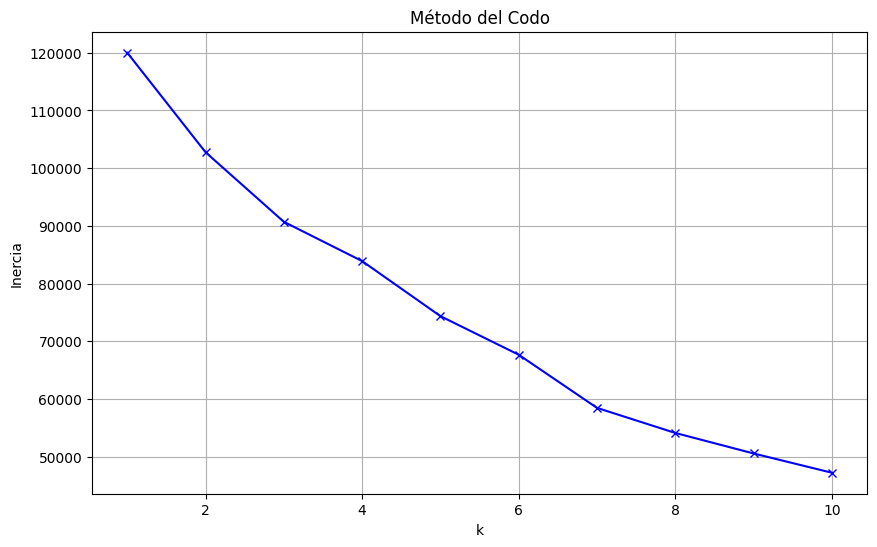

In [87]:

inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.grid(True)
plt.show()

# 1.4 Aplicar K-Means y Clustering Jerárquico #

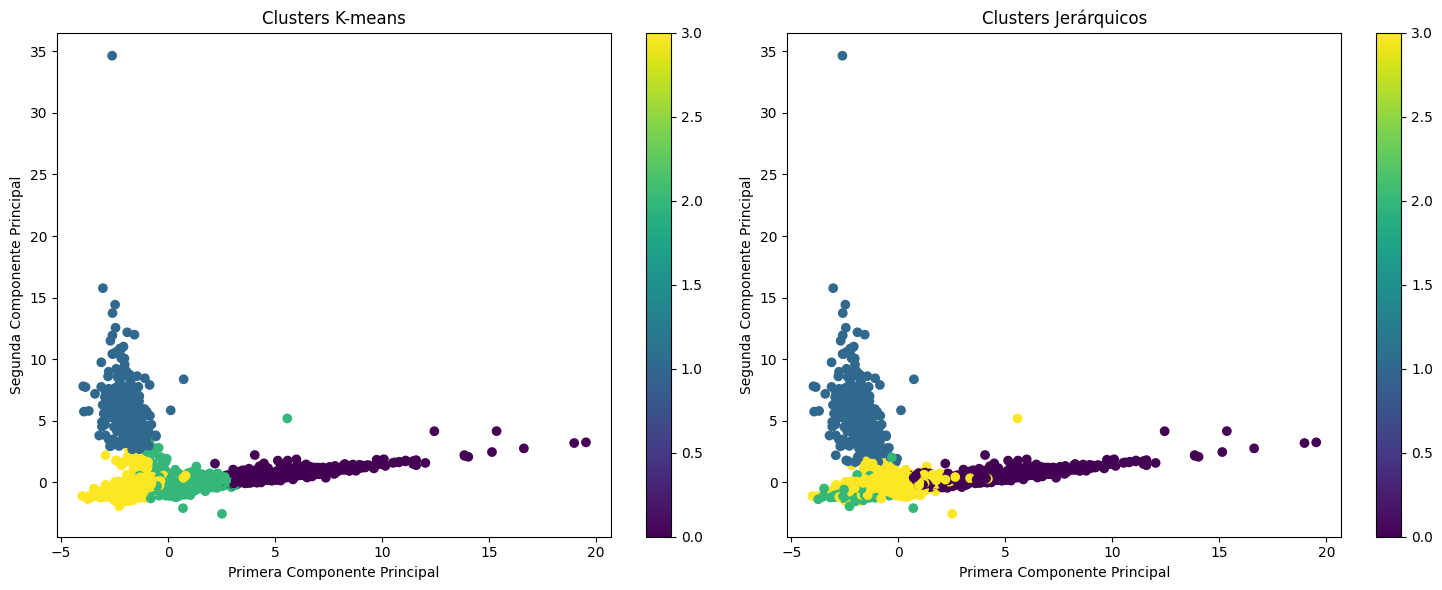


Comparación de tamaños de clusters:
           K-means  Jerárquico
Cluster 0      570        1224
Cluster 1      284         345
Cluster 2     4649         110
Cluster 3     4497        8321

Características promedio de cada cluster:

K-means:


KeyError: 'Cluster_KMeans'

In [88]:

k_optimo = 4


kmeans = KMeans(n_clusters=k_optimo, random_state=42, n_init=10)
clusters_kmeans = kmeans.fit_predict(X_scaled)

Z = linkage(X_scaled, method='ward')


clusters_jerarquico = fcluster(Z, k_optimo, criterion='maxclust')
clusters_jerarquico = clusters_jerarquico - 1

clusters_kmeans = kmeans.fit_predict(X_scaled)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
scatter_kmeans = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_kmeans, cmap='viridis')
plt.title('Clusters K-means')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.colorbar(scatter_kmeans)

plt.subplot(1, 2, 2)
scatter_hier = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_jerarquico, cmap='viridis')
plt.title('Clusters Jerárquicos')
plt.xlabel('Primera Componente Principal')
plt.ylabel('Segunda Componente Principal')
plt.colorbar(scatter_hier)

plt.tight_layout()
plt.show()

sizes_comparison = pd.DataFrame({
    'K-means': [np.sum(clusters_kmeans == i) for i in range(k_optimo)],
    'Jerárquico': [np.sum(clusters_jerarquico == i) for i in range(k_optimo)]
}, index=[f'Cluster {i}' for i in range(k_optimo)])

print("\nComparación de tamaños de clusters:")
print(sizes_comparison)

print("\nCaracterísticas promedio de cada cluster:")

print("\nK-means:")
for i in range(k_optimo):
    cluster_data = datos_numericos[datos_numericos['Cluster_KMeans'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} elementos):")
    means = cluster_data[columnas_numericas].mean()
    for col, mean in means.items():
        print(f"{col}: {mean:.2f}")

print("\nJerárquico:")
for i in range(k_optimo):
    cluster_data = datos_numericos[datos_numericos['Cluster_Hierarchical'] == i]
    print(f"\nCluster {i} ({len(cluster_data)} elementos):")
    means = cluster_data[columnas_numericas].mean()
    for col, mean in means.items():
        print(f"{col}: {mean:.2f}")



# 1.5 Evaluar la calidad del clustering #

In [ ]:
# 5. Cálculo de siluetas
silhouette_kmeans = silhouette_score(X_scaled, clusters_kmeans)
silhouette_jerarquico = silhouette_score(X_scaled, clusters_jerarquico)

print(f"\nSilueta K-means: {silhouette_kmeans:.3f}")
print(f"Silueta Jerárquico: {silhouette_jerarquico:.3f}")

# Guardar los clusters en el DataFrame original
datos_numericos['Cluster_KMeans'] = clusters_kmeans
datos_numericos['Cluster_Hierarchical'] = clusters_jerarquico


Silueta K-means: 0.152
Silueta Jerárquico: 0.394


In [ ]:
# Gráfico de siluetas
def plot_silhouette(X, cluster_labels, title):
    n_clusters = len(np.unique(cluster_labels))
    
    silhouette_vals = silhouette_samples(X, cluster_labels)
    
    plt.figure(figsize=(10, 6))
    y_lower = 10
    
    for i in range(n_clusters):
        cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        cluster_silhouette_vals.sort()
        
        size_cluster_i = cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = plt.cm.viridis(float(i) / n_clusters)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                         0, cluster_silhouette_vals,
                         facecolor=color, alpha=0.7)
        
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')
        y_lower = y_upper + 10
    
    avg_score = np.mean(silhouette_vals)
    plt.axvline(x=avg_score, color="red", linestyle="--", 
                label=f'Promedio: {avg_score:.3f}')
    
    plt.title(title)
    plt.xlabel('Coeficiente de Silueta')
    plt.ylabel('Cluster')
    plt.legend(loc='lower right')
    plt.tight_layout()

Análisis de Siluetas:


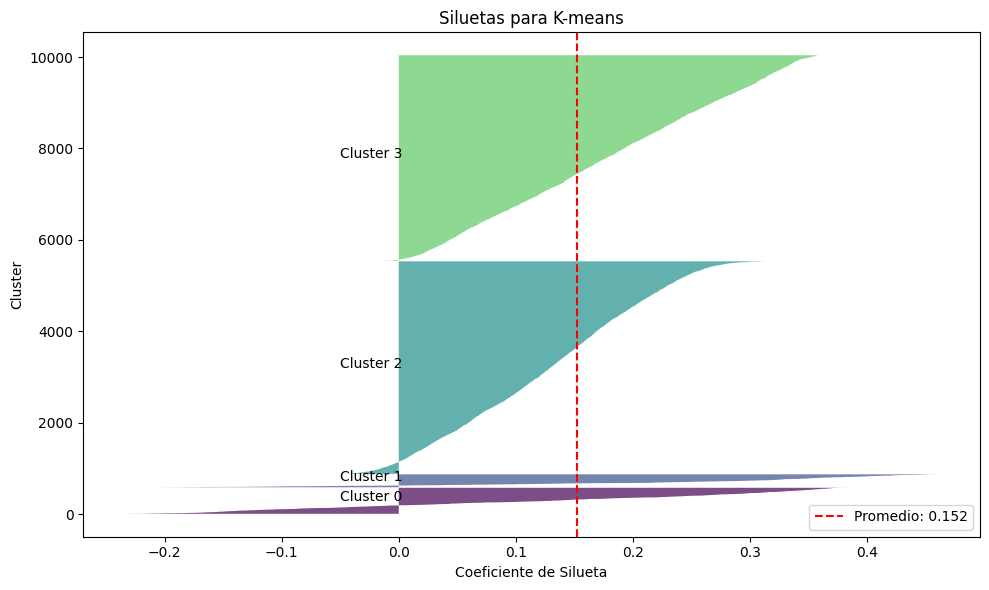

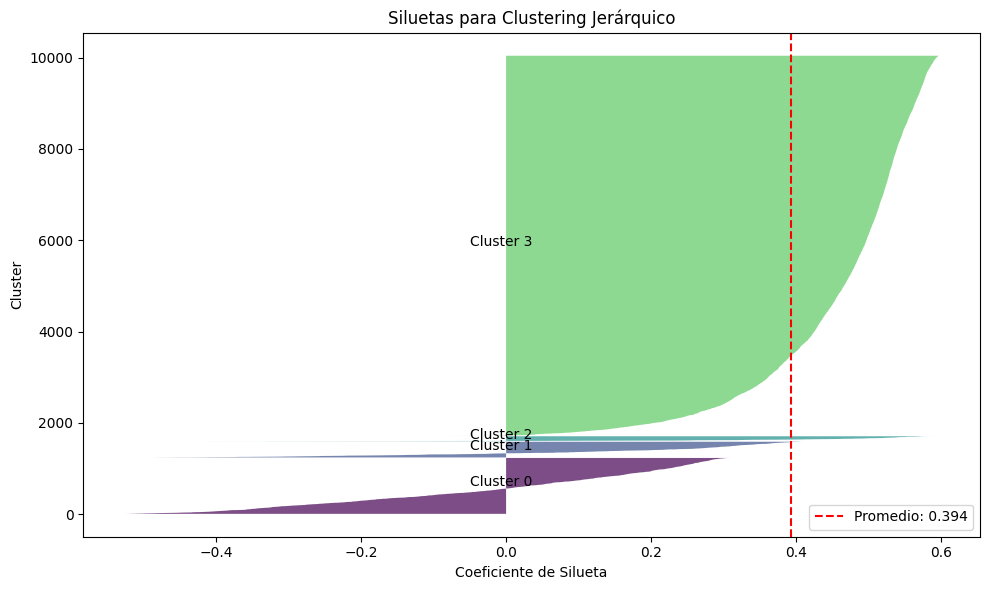

C:\Users\joseb\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


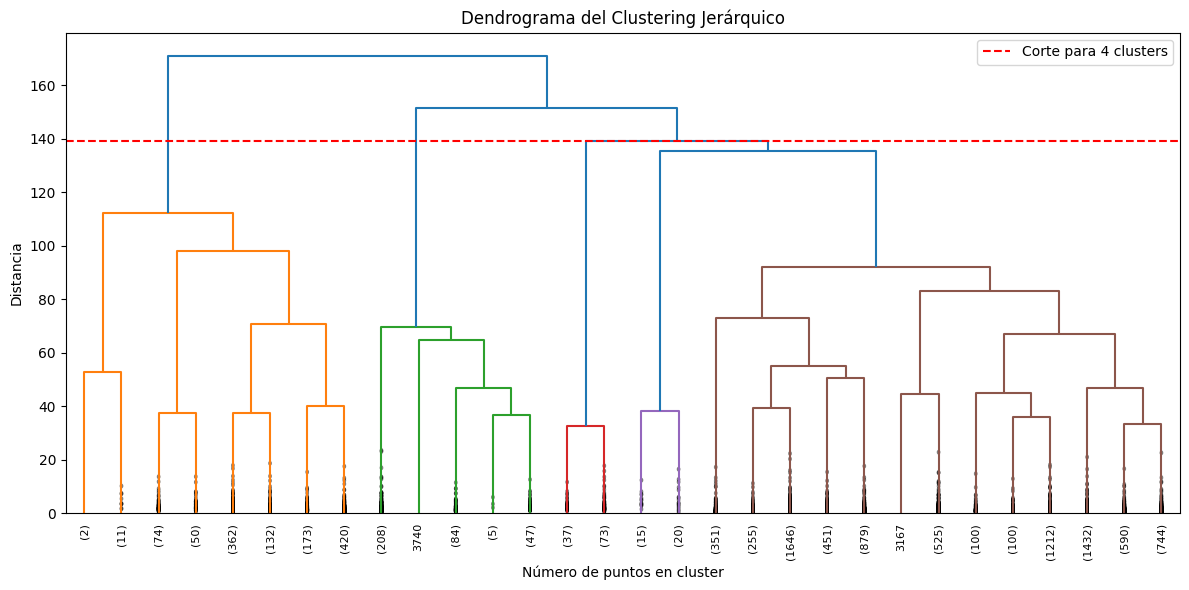

In [ ]:

print("Análisis de Siluetas:")
plot_silhouette(X_scaled, clusters_kmeans, 'Siluetas para K-means')
plt.show()

plot_silhouette(X_scaled, clusters_jerarquico, 'Siluetas para Clustering Jerárquico')
plt.show()

# Generar y visualizar dendrograma
plt.figure(figsize=(12, 6))
dendrogram(Z, 
          truncate_mode='lastp',  # Mostrar solo los últimos p grupos
          p=30,  # Número de grupos a mostrar
          leaf_rotation=90,
          leaf_font_size=8,
          show_contracted=True)

plt.title('Dendrograma del Clustering Jerárquico')
plt.xlabel('Número de puntos en cluster')
plt.ylabel('Distancia')
plt.axhline(y=Z[-(k_optimo-1), 2], color='r', linestyle='--', 
            label=f'Corte para {k_optimo} clusters')
plt.legend()
plt.tight_layout()
plt.show()

# 1.6 Interpretación de los grupos #

In [ ]:
datos_numericos['Cluster_KMeans'] = clusters_kmeans
datos_numericos['Cluster_Hierarchical'] = clusters_jerarquico

# Estadísticas descriptivas por cluster (K-means)
print("\nEstadísticas por cluster (K-means):")
for cluster in range(k_optimo):
    print(f"\nCluster {cluster}:")
    cluster_data = datos_numericos[datos_numericos['Cluster_KMeans'] == cluster]
    print(cluster_data[columnas_numericas].describe())


Estadísticas por cluster (K-means):

Cluster 0:
         popularity        budget       revenue     runtime  genresAmount  \
count    570.000000  5.700000e+02  5.700000e+02  570.000000    570.000000   
mean     229.027881  1.253556e+08  5.095052e+08  122.682456      3.212281   
std      819.332342  6.245353e+07  3.414282e+08   23.003229      0.925440   
min        5.165000  0.000000e+00  0.000000e+00   81.000000      1.000000   
25%       49.747000  8.000000e+07  2.904122e+08  106.000000      3.000000   
50%       88.537000  1.250000e+08  4.111258e+08  120.000000      3.000000   
75%      151.454500  1.650000e+08  6.523665e+08  136.000000      4.000000   
max    11474.647000  3.800000e+08  2.847246e+09  242.000000      6.000000   

       productionCoAmount  productionCountriesAmount     voteCount  \
count          570.000000                 570.000000    570.000000   
mean             3.878947                   1.514035   8790.538596   
std              2.131300                   0.9

# 3.1 Transformacion variables categoricas #

In [ ]:
print("Los principales candidatos que se consideran para transformar son las variables de 'video' y 'genres'\n")

print(datos['video'].value_counts())

print("Debido a la gran proporcion de 'False' que hay con respecto a 'True' para la variable 'video' se considera que no vale la pena hacer la transformacion para incluirla en el PCA.\n")

print(datos['genres'].value_counts())
print("La cantidad total de generos distintos es de:", datos["genres"].nunique())

print("Debido a la gran cantidad de distintos generos que hay se considerar que no vale la pena transformar la variable 'genres' debido a que podria aumentar mucho la dimensionalidad.")



Los principales candidatos que se consideran para transformar son las variables de 'video' y 'genres'

video
False    9430
True       84
Name: count, dtype: int64
Debido a la gran proporcion de 'False' que hay con respecto a 'True' para la variable 'video' se considera que no vale la pena hacer la transformacion para incluirla en el PCA.

genres
Drama                                                                          521
Comedy                                                                         440
Horror                                                                         230
Drama|Romance                                                                  211
Horror|Thriller                                                                205
Comedy|Romance                                                                 201
Documentary                                                                    194
Comedy|Drama                                                           

# 3.2 Indice KMO y Test de esfericidad de Bartlett #

In [ ]:
kmo_all, kmo_model = calculate_kmo(datos_numericos)
print(f"KMO: {kmo_model:.3f}")

test, pvalue = stats.bartlett(datos['popularity'], datos['budget'], datos['revenue'], datos['runtime'], datos['genresAmount'], datos['productionCoAmount'], datos['productionCountriesAmount'], datos['voteCount'], datos['voteAvg'], datos['actorsAmount'], datos['castWomenAmount'], datos['castMenAmount'])
print(f"Valor-p: {pvalue:.3f}")

print("De acuerdo a los resultados del indico KMO y el test de esfericidad de Bartlett, es conveninete realizar un PCA.")



KMO: 0.678
Valor-p: 0.000
De acuerdo a los resultados del indico KMO y el test de esfericidad de Bartlett, es conveninete realizar un PCA.


# 3.3 Analisis de Componentes Principales #

In [ ]:
scaler = StandardScaler()
datos_pca_normal = scaler.fit_transform(datos_numericos)

pca = PCA(n_components=12)

resultados = pca.fit_transform(datos_pca_normal)

datos_pca_final = pd.DataFrame(resultados, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10", "PC11", "PC12",])

datos["PC1"] = datos_pca_final["PC1"]
datos["PC2"] = datos_pca_final["PC2"]
datos["PC3"] = datos_pca_final["PC3"]
datos["PC4"] = datos_pca_final["PC4"]
datos["PC5"] = datos_pca_final["PC5"]
datos["PC6"] = datos_pca_final["PC6"]
datos["PC7"] = datos_pca_final["PC7"]
datos["PC8"] = datos_pca_final["PC8"]
datos["PC9"] = datos_pca_final["PC9"]
datos["PC10"] = datos_pca_final["PC10"]
datos["PC11"] = datos_pca_final["PC11"]
datos["PC12"] = datos_pca_final["PC12"]

print(datos_pca_final.head(), "\n")

print("Varianza explicada por cada componente: " ,pca.explained_variance_ratio_)

print("\nSe puede observar que de los componentes 8 en adelante la variabilidad se reduce considerablemente por lo que se podria considerar conservar unicamente los primeros 8 componentes, sin embargo los primeros 6 componentes ya describen aproximadamente un 60 por ciento de la variabilidad de los datos por lo que se podrian conservar unicamente los primeros 6 componentes sin perder demasiada informacion significativa.")



        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -0.521289 -0.212801  0.050078 -0.326211 -0.384225 -0.545570 -0.409379   
1 -0.199514 -0.162267 -0.306596  0.255337  0.373964  0.051006 -0.097962   
2  6.107210  0.773429 -0.389340 -0.915257 -1.338269 -0.983521  0.743235   
3  7.243330  1.197062  0.496457 -2.051477 -1.887488 -1.619591  0.151244   
4  7.708505  0.967715 -0.530869 -0.655938 -1.446028 -1.507305  0.966724   

        PC8       PC9      PC10      PC11      PC12  
0 -0.365657  0.102798 -0.088068 -0.571659 -0.296941  
1 -0.028177  0.392171 -0.042462  0.288710 -0.037261  
2  1.886518 -0.934655 -0.436458 -3.798764  1.167452  
3  1.535939 -1.289605 -0.704481 -2.020011  1.172154  
4  2.036142 -0.771963 -0.365997 -4.295836 -0.771694   

Varianza explicada por cada componente:  [0.23177385 0.11919518 0.09874402 0.095359   0.08233918 0.08071134
 0.07998224 0.07277063 0.0531864  0.04403103 0.02649054 0.01541658]

Se puede observar que de los componentes 8 en 